In [4]:
%%shell
jupyter nbconvert --to pdf "/content/Topic_Modeling_Code_v3 (3).ipynb"


[NbConvertApp] Converting notebook /content/Topic_Modeling_Code_v3 (3).ipynb to pdf
[NbConvertApp] Support files will be in Topic_Modeling_Code_v3 (3)_files/
[NbConvertApp] Making directory ./Topic_Modeling_Code_v3 (3)_files
[NbConvertApp] Making directory ./Topic_Modeling_Code_v3 (3)_files
[NbConvertApp] Writing 558428 bytes to notebook.tex
[NbConvertApp] Building PDF
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 280, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 423, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_noteb

CalledProcessError: ignored

In [ ]:
!pip install sentence_transformers
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Load Dataframe

In [ ]:
import pandas as pd
# Load the Excel file into a DataFrame
df = pd.read_excel('ACWV Recommendation (2).xlsx', engine='openpyxl')
#df['Recommendation'] = df['Recommendation'].astype(str)
#df['Recommendation'] = df['Comment'].astype(str)

# Define Pre-Proccessing, LDA, and Clustering Functions

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from collections import Counter
import re

# Initialize the lemmatizer and define stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
exclude_words = ['women', 'veterans', 'veteran', 'include', 'va', 'recommend', 'recommendation', 'report', 'acwv', 'military']

# Text preprocessing function
def preprocess_text(text, exclude_words):
    text = str(text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lower case
    words = text.split()  # Split into words

    # Remove stop words and custom excluded words before lemmatization
    words = [word for word in words if word not in stop_words and word not in exclude_words]

    # Apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]


    return ' '.join(words)

# LDA function
def perform_lda(cluster_data, top_words=7, ngram_range=(1,1)):
    # Vectorize data with count vectorizer
    vectorizer = CountVectorizer(ngram_range=ngram_range)

    # transform data into matrix
    dtm = vectorizer.fit_transform(cluster_data)

    # Define LDA Model
    lda = LatentDirichletAllocation(n_components=1, random_state=42)

    # Fit LDA to data
    lda.fit(dtm)

    # Top words in each cluster
    top_words_indices = lda.components_.argsort()[0, -top_words:][::-1]

    # Create Top Words List for Each Cluster
    top_words_list = [vectorizer.get_feature_names_out()[index] for index in top_words_indices]
    return top_words_list

# Main topic modeling function
def perform_topic_modeling(df, column_for_analysis, n_clusters=8, top_words=10, ngram_range=(1,1)):
    df = df.dropna(subset=[column_for_analysis])
    df.reset_index(drop=True, inplace=True)
    df[f'cleaned_{column_for_analysis}'] = df[f'cleaned_{column_for_analysis}'].astype(str)

    # This transformer is trained on a larger corpus of text. I saw that it had the highest scores for clustering on the Hugging Face website
    model = SentenceTransformer('thenlper/gte-large')

    # Encode reviews with transformer model
    encoded_recommendations = model.encode(df[f'cleaned_{column_for_analysis}'])

    # Set number of clusters for K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=777)

    # Fit K-Means to encoded reviews
    kmeans.fit(encoded_recommendations)

    # Fit the cluster to each indice
    cluster_indices = kmeans.predict(encoded_recommendations)

    # Create an empty dictionary to store percentages for each cluster
    cluster_percentages = {}

    # Calculate the percentage of data points in each cluster
    counter = Counter(cluster_indices)
    total_points = len(encoded_recommendations)
    for cluster, count in counter.items():
        percentage = (count / total_points) * 100
        cluster_percentages[cluster] = percentage  # Store the percentage in the dictionary

    # Make sure clustered_recs_df shares the same index with df
    clustered_recs_df = pd.DataFrame({column_for_analysis: df[f'cleaned_{column_for_analysis}'], 'cluster': cluster_indices}, index=df.index)

    # Merge the original DataFrame with the cluster information
    df = pd.merge(df, clustered_recs_df[['cluster']], left_index=True, right_index=True, how='left')

    for i in range(n_clusters):
        # If the index of the cluster is equal to the counter then add the review to the cluster data variable
        cluster_data = clustered_recs_df[clustered_recs_df['cluster'] == i][column_for_analysis]
        if cluster_data.empty:
            continue
        # Perform topic modeling for the current cluster of words
        top_words_list = perform_lda(cluster_data, top_words=top_words, ngram_range=ngram_range)

        # Retrieve the percentage from the dictionary using the cluster index 'i'
        percentage = cluster_percentages.get(i, 0)  # Default to 0 if the cluster is not found

        print(f'''
        Cluster #{i} accounts for {percentage:.2f}% of the data
        Top {top_words} words in {column_for_analysis}: {top_words_list}\n
        ''')

    return df



# Topic Model for Recommendations
### **Six clusters and tri grams**

In [ ]:
# Define words to be excluded and define column for analysis
exclude_words = ['women', 'veterans', 'veteran', 'include', 'va', 'recommend', 'recommendation', 'report', 'acwv', 'military']
column_for_analysis = "Recommendation"

# Pre Process data
df[f'cleaned_{column_for_analysis}'] = df[column_for_analysis].apply(lambda x: preprocess_text(x, exclude_words))

# Run model for tri grams
print(f"Performing topic modeling for all {column_for_analysis}...")
recs_six_clusters_and_trigrams_df = perform_topic_modeling(df, column_for_analysis, n_clusters=6, ngram_range=((3, 3)))


Performing topic modeling for all Recommendation...

        Cluster #0 accounts for 17.91% of the data
        Top 10 words in Recommendation: ['sexual trauma counseling', 'readjustment counseling service', 'sexual trauma mst', 'sexual assault trauma', 'center team leader', 'vet center team', 'traumatic stress disorder', 'provide sexual trauma', 'mental health service', 'stress disorder ptsd']

        

        Cluster #1 accounts for 13.81% of the data
        Top 10 words in Recommendation: ['health care service', 'benefit health care', 'ensure native american', 'integrated service network', 'american living reservation', 'american medical association', 'medical association american', 'tribal program official', 'transition assistance program', 'assistance program briefing']

        

        Cluster #2 accounts for 21.64% of the data
        Top 10 words in Recommendation: ['program manager position', 'outlined vha handbook', 'vha handbook 13301', 'benefit administration vba', 'po

# Topic Model for Recommendations
### **Seven clusters and LDA with bigrams**

In [ ]:
print(f"Performing topic modeling for all Recommendations...")
recs_seven_clusters_with_bigrams_df = perform_topic_modeling(df, column_for_analysis, n_clusters=7, ngram_range=(2, 2))

Performing topic modeling for all Recommendations...

        Cluster #0 accounts for 19.03% of the data
        Top 10 words in Recommendation: ['health care', 'mental health', 'woman health', 'health service', 'gender specific', 'care provider', 'ensure access', 'performance measure', 'patient satisfaction', 'health screening']

        

        Cluster #1 accounts for 20.52% of the data
        Top 10 words in Recommendation: ['medical center', 'health care', 'program manager', 'vha handbook', 'advisory committee', 'manager position', 'administration vba', 'outlined vha', 'benefit administration', 'wvhp office']

        

        Cluster #2 accounts for 19.40% of the data
        Top 10 words in Recommendation: ['service member', 'active duty', 'department affair', 'advisory committee', 'national guard', 'service vet', 'position within', 'labor dol', 'training service', 'selected reserve']

        

        Cluster #3 accounts for 9.33% of the data
        Top 10 words in Recomme

# Topic Modeling for VA Comments
### **Concurred, Nonconcurred, Concur in Principle**

In [ ]:
# Count of Nonconcur Recommendations
nonconcur_count = df['Result '].value_counts().get('Nonconcur', 0)
concur_in_principle_count = df['Result '].value_counts().get('Concur in principle', 0)
concur_count = df['Result '].value_counts().get('Concur', 0)
print(f"Number of 'Nonconcur' recommendations: {nonconcur_count}")
print(f"Number of 'Concur in principle' recommendations: {concur_in_principle_count}")
print(f"Number of 'Concur in principle' recommendations: {concur_count}")

Number of 'Nonconcur' recommendations: 32
Number of 'Concur in principle' recommendations: 63
Number of 'Concur in principle' recommendations: 173


# Topic Model for VA Comments
### **Nonconcur - Four clusters and 4 grams**

In [ ]:
# Create dataframe with nonconcur recommendations
nonconcur_recs_df = df[df['Result '] == 'Nonconcur']

# Set words to be excluded from corpus
exclude_words = ['women', 'veterans', 'veteran', 'include', 'va', 'recommend', 'recommendation', 'report', 'acwv', 'military']

# Set Column for analysis
column_for_analysis = "Comment"

# Pre-Process VA Comment data
nonconcur_recs_df = nonconcur_recs_df.copy()
nonconcur_recs_df[f'cleaned_{column_for_analysis}'] = nonconcur_recs_df[column_for_analysis].apply(lambda x: preprocess_text(x, exclude_words))

# Run Topic Model
print(f"Performing topic modeling for all {column_for_analysis}...")
nonconcur_recs_df.reset_index(drop=True, inplace=True)
comments_nonconcur_four_clusters_and_4grams_df = perform_topic_modeling(nonconcur_recs_df, column_for_analysis, n_clusters=4, ngram_range=((4, 4)))

Performing topic modeling for all Comment...

        Cluster #0 accounts for 31.58% of the data
        Top 10 words in Comment: ['policy requires facility wvpm', 'year additionally vha produce', 'general information service homeless', 'fee software package financial', 'financial system designed serve', 'focus quality care rather', 'followup alert cpr could', 'found even woman unit', 'friendly domiciliary program expected', 'fulltime administrative position without']

        

        Cluster #1 accounts for 31.58% of the data
        Top 10 words in Comment: ['experience sexual trauma active', 'criterion sexual trauma counseling', 'july 1997 however indicated', 'selective reserve national guard', 'selected reserve national guard', 'assault performing duty general', 'law member selective reserve', 'reserve national guard component', 'reserve national guard also', 'victimization limited active duty']

        

        Cluster #2 accounts for 15.79% of the data
        Top 10 words in

In [ ]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)
comments_nonconcur_four_clusters_and_4grams_df[comments_four_clusters_and_4grams_df['cluster_y'] == 0]

Clustering the VA response from the recommendations may serve to be purposeless for nonconcur recommendations. There simply isn't enough recommendation data to justify clustering the data.

# Concurred Recommendations Topic Model

In [ ]:
# Create dataframe with nonconcur recommendations
concur_recs_df = df[df['Result '] == 'Concur']

# Set words to be excluded from corpus
exclude_words = ['women', 'veterans', 'veteran', 'include', 'va', 'recommend', 'recommendation', 'report', 'acwv', 'military']

# Set Column for analysis
column_for_analysis = "Comment"

# Pre-Process VA Comment data
concur_recs_df = concur_recs_df.copy()
concur_recs_df[f'cleaned_{column_for_analysis}'] = concur_recs_df[column_for_analysis].apply(lambda x: preprocess_text(x, exclude_words))

# Run Topic Model
print(f"Performing topic modeling for all {column_for_analysis}...")
concur_recs_df.reset_index(drop=True, inplace=True)
comments_concur_four_clusters_and_4grams_df = perform_topic_modeling(concur_recs_df, column_for_analysis, n_clusters=6, ngram_range=((2, 2)))

Performing topic modeling for all Comment...

        Cluster #0 accounts for 11.56% of the data
        Top 10 words in Comment: ['community care', 'outreach program', 'adverse credit', 'community provider', 'service organization', 'health care', 'care service', 'credit reporting', 'fact sheet', 'benefit service']

        

        Cluster #1 accounts for 21.97% of the data
        Top 10 words in Comment: ['mental health', 'woman health', 'health care', 'whole health', 'health service', 'primary care', 'health research', 'research development', 'medical center', 'sexual trauma']

        

        Cluster #2 accounts for 17.92% of the data
        Top 10 words in Comment: ['advisory committee', 'sexual trauma', 'current status', 'health care', '2002 advisory', 'readjustment counseling', 'regional office', 'employment service', 'vocational rehabilitation', 'sexual assault']

        

        Cluster #3 accounts for 12.14% of the data
        Top 10 words in Comment: ['homeless progr

# Examine Data frame that has the right number of clusters.

In [ ]:
# Change settings to display entire table
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)
#df_2[df_2['cluster']== 5]

**Cluster 0** - Aruguably is Health Care
/n **Cluster 1** - Is about sexual assualt - THIS BY FAR IS THE MOST CONCISE AND MOST OF THE RECOMMENDATIONS
**Cluster 2** - Homelessness
**Cluster 3** - Organizational changes, Changes in the business, work related, benefits,
**Cluster 4** - Questionable
**Cluster 5** - Outreach to collect data to refine on  information

# Finding the Optimal Number of Clusters for Recommendations Overall

**Elbow Method for Recommendations**

C:\Users\Michael W. Rowe II\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


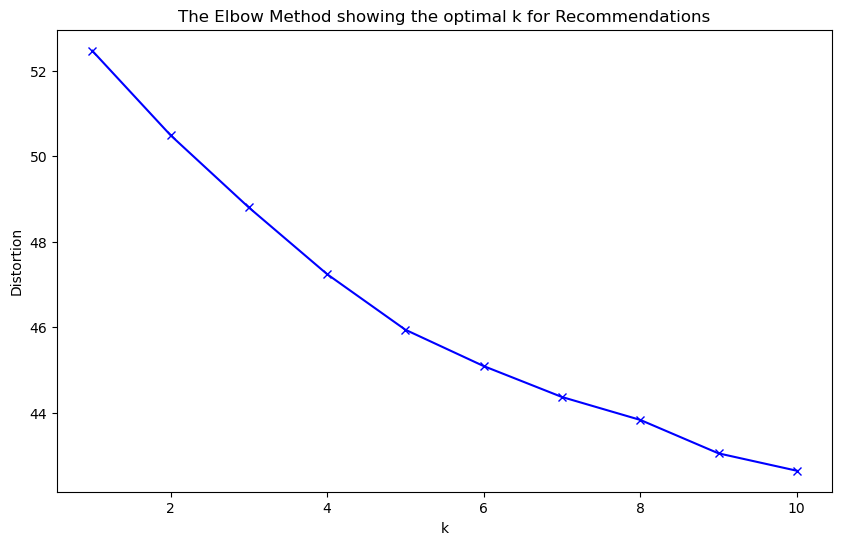

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

column_for_analysis = "Recommendation"

# This transformer is trained on a larger corpus of text. I saw that it had the highest scores for clustering on the Hugging Face website
model = SentenceTransformer('thenlper/gte-large')

# Encode reviews with transformer model
encoded_recommendations = model.encode(df[f'cleaned_{column_for_analysis}'])

# Compute distortions
distortions = []
K = range(1, 11)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state = 777)
    kmeanModel.fit(encoded_recommendations)
    distortions.append(kmeanModel.inertia_)

# Plot the elbow
plt.figure(figsize=(10,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k for Recommendations')
plt.show()


This optimal number of clusters for recommendations appear to be around 6 to 8 for recommendations.

**Elbow Method for VA Comments**

C:\Users\Michael W. Rowe II\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


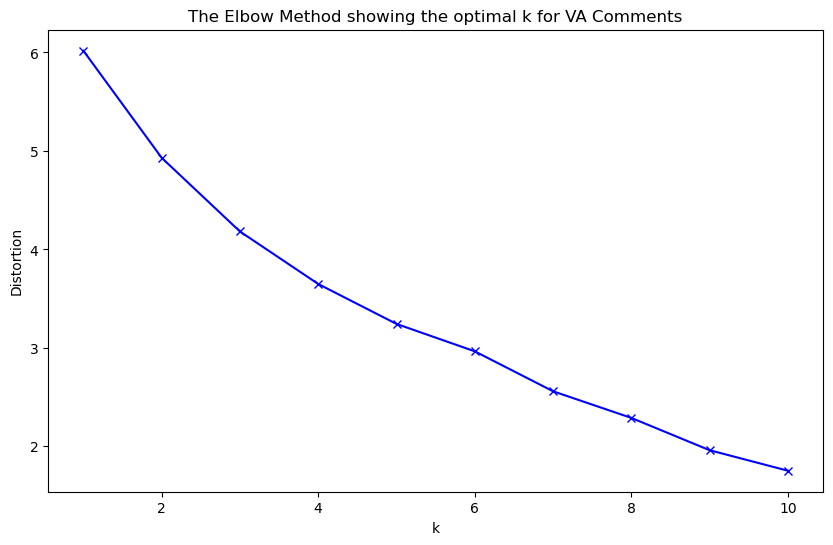

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

column_for_analysis = "Comment"
exclude_words = ['women', 'veterans', 'veteran', 'include', 'va', 'recommend', 'recommendation', 'report', 'acwv', 'military']

# Run model for tri grams
nonconcur_recs_df[f'cleaned_{column_for_analysis}'] = df[column_for_analysis].apply(lambda x: preprocess_text(x, exclude_words))

# This transformer is trained on a larger corpus of text. I saw that it had the highest scores for clustering on the Hugging Face website
model = SentenceTransformer('thenlper/gte-large')

# Encode reviews with transformer model
encoded_recommendations = model.encode(nonconcur_recs_df[f'cleaned_{column_for_analysis}'])

# Compute distortions
distortions = []
K = range(1, 11)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state = 777)
    kmeanModel.fit(encoded_recommendations)
    distortions.append(kmeanModel.inertia_)

# Plot the elbow
plt.figure(figsize=(10,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k for VA Comments')
plt.show()
